In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
combined=pd.read_csv("/content/drive/MyDrive/data/metadata/dish_metadata_combined.csv")
combined.head()

,dish_id,total_calories,total_mass,total_carb,total_fat,total_protein
0,dish_1561662216,300.794281,193.0,28.218290,12.387489,18.633970
1,dish_1562688426,137.569992,88.0,5.190000,8.256000,10.297000
2,dish_1561662054,419.438782,292.0,26.351543,23.838249,25.910593
3,dish_1562008979,382.936646,290.0,10.173570,22.224644,35.345387
4,dish_1560455030,20.590000,103.0,4.625000,0.148000,0.956000


In [3]:
!pip install torchvision
import torchvision.transforms as transforms

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# Data Loader

In [4]:
import imageio.v3 as iio
from PIL import Image, UnidentifiedImageError  # Import UnidentifiedImageError
import torch
from torch.utils.data import Dataset
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
class CustomDatasetWithCSV(Dataset):
    def __init__(self, root_dir, csv_data):
        self.root_dir = root_dir
        self.csv_data = csv_data
        self.subfolders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
        random.shuffle(self.subfolders)

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        folder_name = self.subfolders[idx]
        rgb_folder = os.path.join(self.root_dir, folder_name)
        depth_folder = os.path.join(self.root_dir, folder_name)

        rgb_img_path = os.path.join(rgb_folder, 'rgb.png')
        depth_img_path = os.path.join(depth_folder, 'depth_raw.png')

        try:
            rgb_img = Image.open(rgb_img_path)
            depth_img = Image.open(depth_img_path)
        except (FileNotFoundError, UnidentifiedImageError) as e:
            print(f"Error opening image(s) for folder {folder_name}: {e}")
            # Skip to the next iteration if image(s) not found
            return self.__getitem__((idx + 1) % len(self))

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        rgb_img = transform(rgb_img)
        depth_img = transform(depth_img)

        dish_id = folder_name
        csv_row = self.csv_data[self.csv_data['dish_id'] == dish_id]
        if len(csv_row) == 0:
            y = torch.zeros(5, dtype=torch.float32)
        else:
            csv_row = csv_row.iloc[0]
            y = torch.tensor(csv_row[['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']], dtype=torch.float32)

        return (rgb_img, depth_img, y)

# Instantiate the dataset with CSV data
root_dir="/content/drive/MyDrive/data/realsense_overhead"
dataset = CustomDatasetWithCSV(root_dir, combined)

In [5]:
dataset[0][1].shape

torch.Size([1, 224, 224])

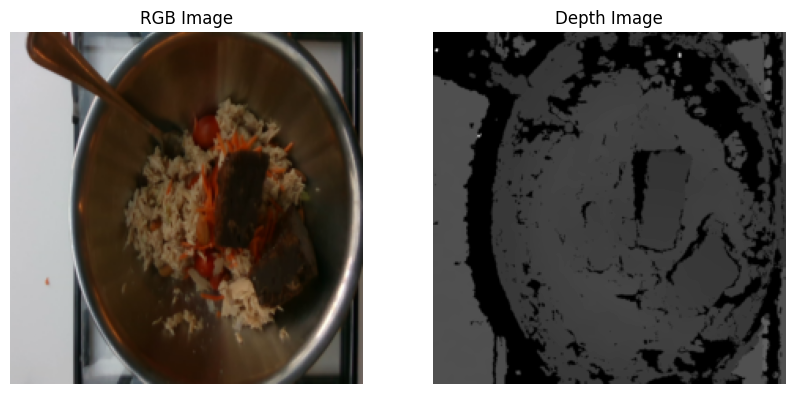

In [6]:
import matplotlib.pyplot as plt

# Access the first item in the dataset
rgb_img, depth_img, label = dataset[0]

# Convert tensor to numpy array and transpose dimensions
rgb_img_np = rgb_img.permute(1, 2, 0).numpy()
depth_img_np = depth_img.squeeze().numpy()  # Depth image is 3D, so squeeze it to 2D
label_np = label.numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display RGB image
axes[0].imshow(rgb_img_np)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Display depth image
axes[1].imshow(depth_img_np, cmap='gray')
axes[1].set_title('Depth Image')
axes[1].axis('off')

# Display the figure
plt.show()

# Display label
print("Label: (total_calories, total_mass, total_fat, total_carb, total_protein):", label_np)

In [7]:
# Split dataset into train and test sets
train_percent = 0.9
train_size = int(train_percent * len(dataset))
test_size = len(dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator1)

Label: (total_calories, total_mass, total_fat, total_carb, total_protein): [508.04898  109.        31.391998  54.281998   6.758   ]


In [8]:
print(len(train_dataset))
print(len(test_dataset))

3141
349


In [9]:
# Set batch size according to your needs
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

In [10]:
import torch
import torch.nn as nn

class CustomModelWithCSV(nn.Module):
    def __init__(self, rgb_input_size, depth_input_size):
        super(CustomModelWithCSV, self).__init__()

        # Define convolutional layers for processing RGB images
        self.rgb_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization layer
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Define convolutional layers for processing depth images
        self.depth_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # Adjusted depth convolutional layers
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),  # Adjusted depth convolutional layers
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate input size for the first linear layer
        combined_features_size = 32 * ((rgb_input_size // 2) * (rgb_input_size // 2)) + 32 * ((depth_input_size // 4) * (depth_input_size // 4))

        # Define fully connected layers for combining features and predicting output
        self.fc_combined = nn.Sequential(
            nn.Linear(combined_features_size, 128),  # Concatenate image and CSV features
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),  # Output will have 5 dimensions: calories, mass, fat, carb, protein
            nn.ReLU()
        )

    def forward(self, rgb_img, depth_img):
        # Process RGB and depth images through respective convolutional layers
        rgb_features = self.rgb_conv(rgb_img)
        depth_features = self.depth_conv(depth_img)
        # Flatten features
        rgb_features = rgb_features.view(rgb_features.size(0), -1)
        depth_features = depth_features.view(depth_features.size(0), -1)

        # Concatenate image features and CSV features
        combined_features = torch.cat((rgb_features, depth_features), dim=1)

        # Pass through fully connected layers
        output = self.fc_combined(combined_features)
        return output


# Instantiate the model with input sizes for RGB and depth images
rgb_input_size = 224  # Assuming RGB images are resized to 224x224
depth_input_size = 224  # Assuming depth images are resized to 224x224
model_with_csv = CustomModelWithCSV(rgb_input_size, depth_input_size)

In [11]:
print(model_with_csv)

CustomModelWithCSV(
  (rgb_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (depth_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=501760, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=

In [12]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=21e8267fe4cec53909bd1e10dc3b4d5897cbb53c708f6b9b1d9d98fff21e6872
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


# Training

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Define the loss function (criterion)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model_with_csv.parameters(), lr=0.001)  # You can adjust the learning rate as needed

# Lists to store training loss and validation loss for plotting
train_loss_history = []
test_loss_history = []
num_epochs=10

# Train the model
for epoch in range(num_epochs):
    model_with_csv.train()  # Set model to training mode
    running_loss = 0.0

    for batch_idx, (rgb_imgs, depth_imgs, targets) in enumerate(train_loader):
        if (rgb_imgs.numel() == 0 or depth_imgs.numel() == 0 or targets.numel() == 0):
            print(f"Warning: Skipping batch {batch_idx} due to missing data")
            continue

        # Zero the parameter gradients
        optimizer.zero_grad()
        rgb_imgs = rgb_imgs.float()
        depth_imgs = depth_imgs.float()

        # Forward pass
        outputs = model_with_csv(rgb_imgs, depth_imgs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item() * rgb_imgs.size(0)

    # Print statistics and store training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    train_loss_history.append(epoch_loss)

    # Evaluate on the test set
    model_with_csv.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for rgb_imgs, depth_imgs, targets in test_loader:
            rgb_imgs = rgb_imgs.float()
            depth_imgs = depth_imgs.float()

            # Forward pass
            outputs = model_with_csv(rgb_imgs, depth_imgs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Track loss
            test_loss += loss.item() * rgb_imgs.size(0)

    # Print evaluation statistics and store test loss
    test_loss /= len(test_loader.dataset)
    print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
    test_loss_history.append(test_loss)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')